In [1]:
# Data processing
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings  
warnings.filterwarnings("ignore") 

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_regression import RegressionModels

In [2]:
df = pd.read_csv('../data/output/api_rent_madrid_preprocessed.csv', index_col=0).reset_index(drop=True)
df.head()

,price,size,exterior,rooms,bathrooms,distance,municipality,province,hasLift,numPhotos,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,floor
0,550.0,8.442463,False,4.410093,3,1.048670,657.095509,579.687729,661.431099,1.152172,1.0,0.0,0.0,0.0,0.0,0.0,13.0
1,750.0,-0.221149,True,-0.712507,1,-0.896578,705.594108,693.233618,677.631111,-1.021827,0.0,0.0,0.0,1.0,0.0,0.0,6.0
2,750.0,0.057424,True,0.312013,1,-0.360972,685.520603,693.233618,670.210811,-0.090113,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,400.0,-0.026148,True,0.312013,2,1.926351,637.579238,693.233618,670.210811,0.634554,0.0,0.0,0.0,0.0,1.0,0.0,5.0
4,450.0,0.586712,False,0.312013,1,1.464429,644.084662,579.687729,677.631111,0.013411,0.0,0.0,0.0,1.0,0.0,0.0,5.0


### Model execution

In this notebook, we will run a random forest model for our data.

In [6]:
params_rf = {
    'max_depth': range(3, 10),
    'min_samples_split': range(6, 16),
    'min_samples_leaf': range(2, 6),
    'max_leaf_nodes': range(5, 105, 10)
}

In [7]:
forest_model = RegressionModels(df, 'price', frac=0.8, seed=2)

results = forest_model.model_fit("random_forest", params_rf)
forest_model.get_results()
forest_model.get_metrics("random_forest").round(2)

,R2,MAE,RMSE
train,0.77,29.32,38.87
test,0.79,30.85,42.15


Best model:
RandomForestRegressor(max_depth=9, max_leaf_nodes=35, min_samples_leaf=4,
                      min_samples_split=13)


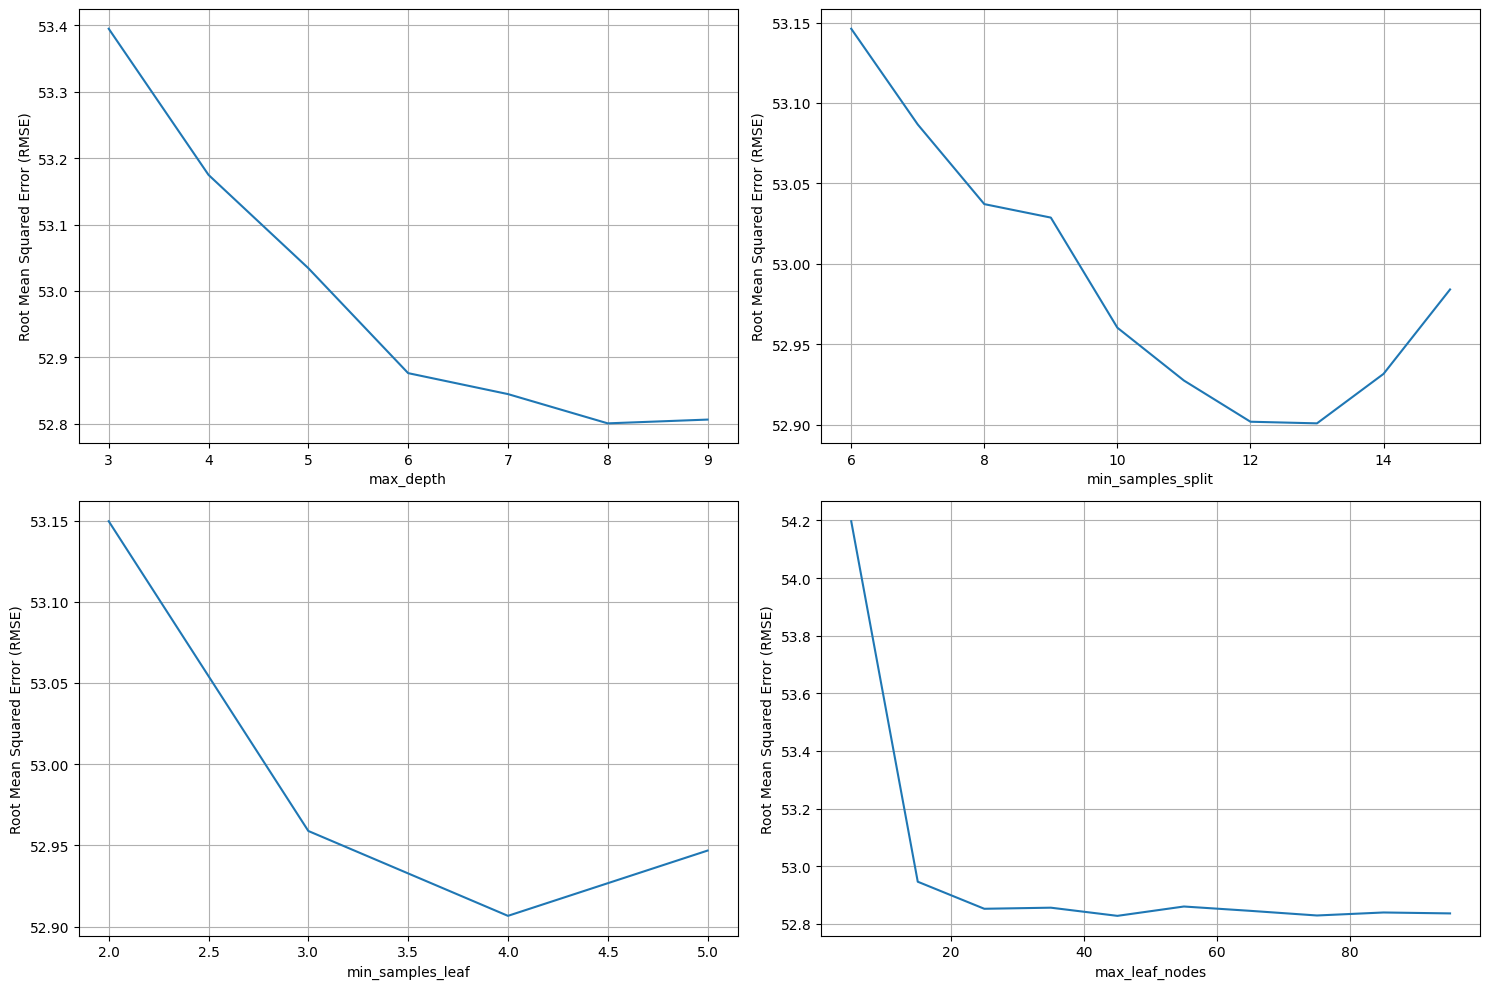

In [8]:
forest_model.plot_best_model(results, 'random_forest')

It is the best combination we have found. The results are slightly better than those of the decision tree model, with a higher $ R^2 $ and a slightly lower `RMSE`.

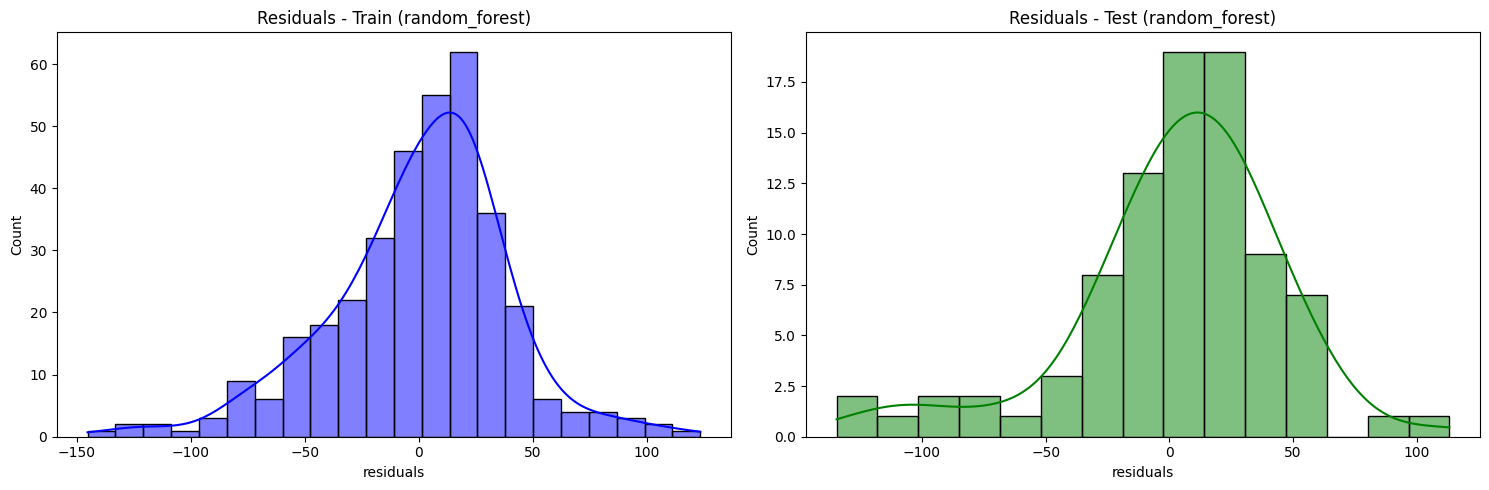

In [11]:
forest_model.plot_residuals('random_forest')

The residuals are even more centered, with identical distribution compared to previous models.

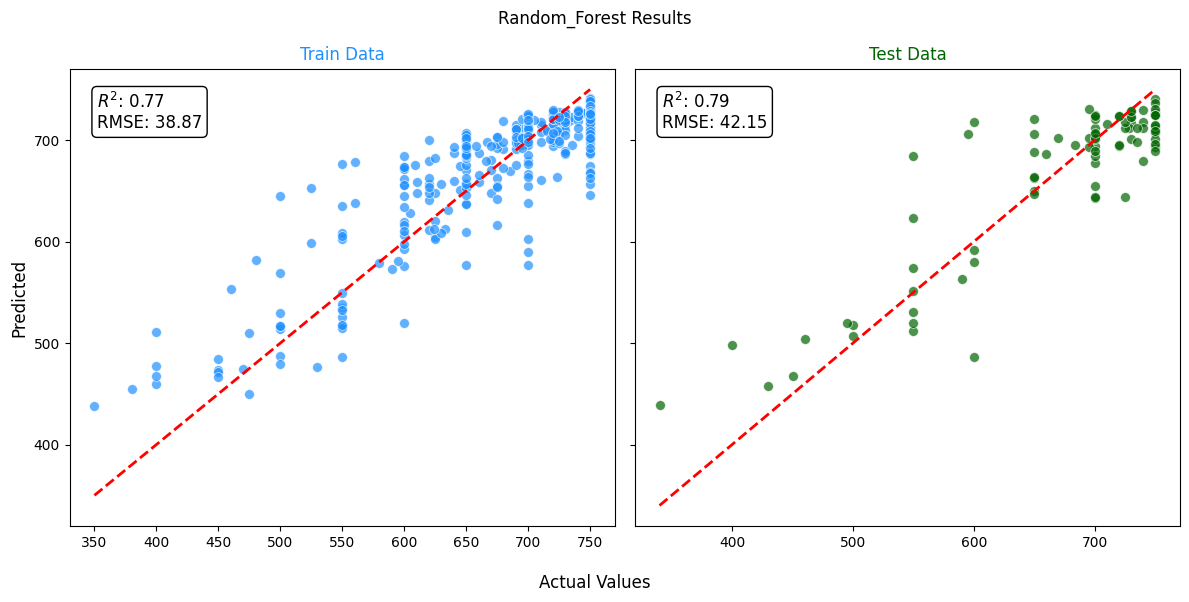

In [13]:
forest_model.plot_actual_vs_prediction('random_forest')

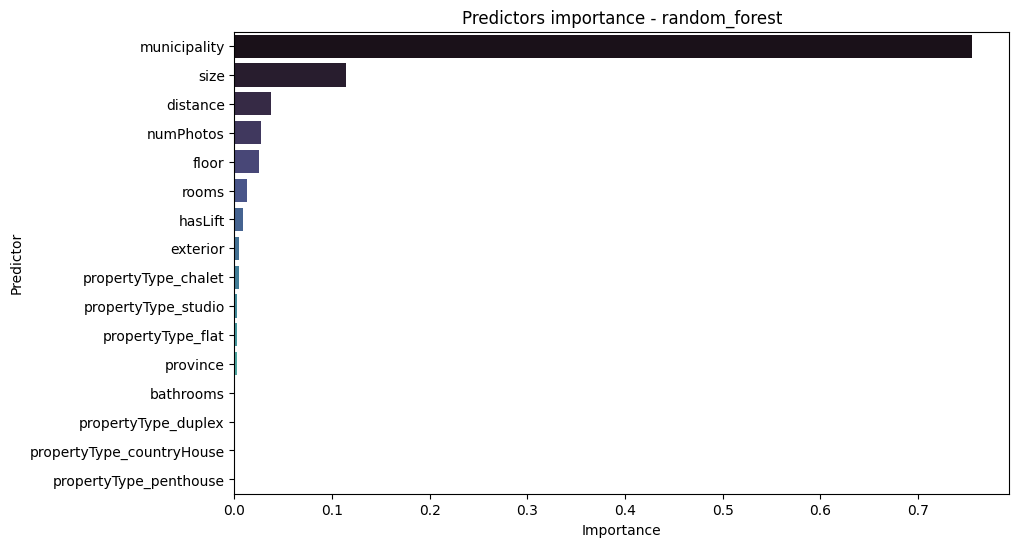

,Predictor,Importance
5,municipality,0.755750
0,size,0.114430
4,distance,0.037414
8,numPhotos,0.027380
15,floor,0.025500
2,rooms,0.012769
7,hasLift,0.009038
1,exterior,0.005141
9,propertyType_chalet,0.004525
14,propertyType_studio,0.002254


In [14]:
forest_model.predictors_importance('random_forest')

Top3 important variables are the same as in decision tree model. Let's try again and dropping not important columns

In [16]:
df2 = df.copy()

In [17]:
df2.drop(columns=['propertyType_penthouse', 'propertyType_countryHouse'], inplace=True)

In [18]:
forest_model2 = RegressionModels(df2, 'price', frac=0.8, seed=2)
results2 = forest_model2.model_fit("tree", params_rf)
forest_model2.get_results()
forest_model2.get_metrics("tree").round(2)

,R2,MAE,RMSE
train,0.75,30.55,40.54
test,0.76,34.12,45.51


The result is slightly worse so we keep the first model

### Model dump

In [19]:
with open('../models/forest_model.pkl', 'wb') as f:
    pickle.dump(forest_model, f)